In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_kcat = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/kcat_with_features.joblib')
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,log10kcat_max,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [3]:
data_kcat.rename(columns={'log10kcat_max':'label'},inplace=True)
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,label,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_kcat, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define MLP Model for Regression
class MLPRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim=1):
        super(MLPRegressor, self).__init__()

        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        
        # norm layer + Dropout
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)

        # hidden layer + output layer
        self.hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_embedding = self.activation(self.mol_encoder(mol_input))
        protein_embedding = self.activation(self.protein_encoder(protein_input))

        # Concatenate + Normalize + Dropout
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Hidden → Regress
        hidden_out = self.activation(self.hidden(combined))
        output = self.regressor(hidden_out)

        return output.squeeze(1)


In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim,hidden_dim=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1: 100%|██████████| 507/507 [00:04<00:00, 106.95it/s]


Epoch 0 - Train Loss: 2.5499, Train MSE: 2.5515, Train MAE: 1.2198


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_16830/3008050676.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.2669, Validation MSE: 2.2672, Validation MAE: 1.1604


Training Epoch 11: 100%|██████████| 507/507 [00:04<00:00, 118.55it/s]


Epoch 10 - Train Loss: 1.5940, Train MSE: 1.5934, Train MAE: 0.9529
Epoch 10 - Validation Loss: 1.6677, Validation MSE: 1.6702, Validation MAE: 0.9756


Training Epoch 21: 100%|██████████| 507/507 [00:04<00:00, 115.78it/s]


Epoch 20 - Train Loss: 1.2255, Train MSE: 1.2268, Train MAE: 0.8305
Epoch 20 - Validation Loss: 1.5206, Validation MSE: 1.5238, Validation MAE: 0.9266


Training Epoch 31: 100%|██████████| 507/507 [00:06<00:00, 76.67it/s] 


Epoch 30 - Train Loss: 0.9921, Train MSE: 0.9927, Train MAE: 0.7459
Epoch 30 - Validation Loss: 1.4560, Validation MSE: 1.4587, Validation MAE: 0.8979


Training Epoch 41: 100%|██████████| 507/507 [00:04<00:00, 103.61it/s]


Epoch 40 - Train Loss: 0.8502, Train MSE: 0.8505, Train MAE: 0.6926
Epoch 40 - Validation Loss: 1.3828, Validation MSE: 1.3856, Validation MAE: 0.8758


Training Epoch 51: 100%|██████████| 507/507 [00:05<00:00, 98.50it/s] 


Epoch 50 - Train Loss: 0.7449, Train MSE: 0.7441, Train MAE: 0.6449
Epoch 50 - Validation Loss: 1.3772, Validation MSE: 1.3806, Validation MAE: 0.8618


Training Epoch 61: 100%|██████████| 507/507 [00:04<00:00, 109.61it/s]


Epoch 60 - Train Loss: 0.6645, Train MSE: 0.6646, Train MAE: 0.6121
Epoch 60 - Validation Loss: 1.3697, Validation MSE: 1.3732, Validation MAE: 0.8512


Training Epoch 71: 100%|██████████| 507/507 [00:05<00:00, 94.74it/s] 


Epoch 70 - Train Loss: 0.5949, Train MSE: 0.5942, Train MAE: 0.5778
Epoch 70 - Validation Loss: 1.3469, Validation MSE: 1.3499, Validation MAE: 0.8408


Training Epoch 81: 100%|██████████| 507/507 [00:04<00:00, 101.90it/s]


Epoch 80 - Train Loss: 0.5393, Train MSE: 0.5395, Train MAE: 0.5493
Epoch 80 - Validation Loss: 1.3363, Validation MSE: 1.3397, Validation MAE: 0.8433


Training Epoch 91: 100%|██████████| 507/507 [00:05<00:00, 90.77it/s]


Epoch 90 - Train Loss: 0.5161, Train MSE: 0.5164, Train MAE: 0.5377
Epoch 90 - Validation Loss: 1.3567, Validation MSE: 1.3601, Validation MAE: 0.8423


Training Epoch 101: 100%|██████████| 507/507 [00:06<00:00, 80.18it/s]


Epoch 100 - Train Loss: 0.4894, Train MSE: 0.4893, Train MAE: 0.5216
Epoch 100 - Validation Loss: 1.3293, Validation MSE: 1.3312, Validation MAE: 0.8355


Training Epoch 111: 100%|██████████| 507/507 [00:06<00:00, 77.47it/s]


Epoch 110 - Train Loss: 0.4601, Train MSE: 0.4601, Train MAE: 0.5050
Epoch 110 - Validation Loss: 1.3331, Validation MSE: 1.3354, Validation MAE: 0.8348


Training Epoch 121: 100%|██████████| 507/507 [00:06<00:00, 80.95it/s]


Epoch 120 - Train Loss: 0.4211, Train MSE: 0.4214, Train MAE: 0.4841
Epoch 120 - Validation Loss: 1.3192, Validation MSE: 1.3224, Validation MAE: 0.8291


Training Epoch 131: 100%|██████████| 507/507 [00:06<00:00, 79.90it/s]


Epoch 130 - Train Loss: 0.4080, Train MSE: 0.4070, Train MAE: 0.4742
Epoch 130 - Validation Loss: 1.3059, Validation MSE: 1.3091, Validation MAE: 0.8229


Training Epoch 141: 100%|██████████| 507/507 [00:05<00:00, 96.92it/s] 


Epoch 140 - Train Loss: 0.3939, Train MSE: 0.3939, Train MAE: 0.4654
Epoch 140 - Validation Loss: 1.3161, Validation MSE: 1.3192, Validation MAE: 0.8193


Training Epoch 151: 100%|██████████| 507/507 [00:05<00:00, 93.03it/s]


Epoch 150 - Train Loss: 0.3710, Train MSE: 0.3712, Train MAE: 0.4546
Epoch 150 - Validation Loss: 1.3246, Validation MSE: 1.3273, Validation MAE: 0.8205


Training Epoch 161: 100%|██████████| 507/507 [00:04<00:00, 116.14it/s]


Epoch 160 - Train Loss: 0.3652, Train MSE: 0.3651, Train MAE: 0.4478
Epoch 160 - Validation Loss: 1.2975, Validation MSE: 1.3007, Validation MAE: 0.8174


Training Epoch 171: 100%|██████████| 507/507 [00:04<00:00, 118.19it/s]


Epoch 170 - Train Loss: 0.3448, Train MSE: 0.3448, Train MAE: 0.4366
Epoch 170 - Validation Loss: 1.3043, Validation MSE: 1.3073, Validation MAE: 0.8175


Training Epoch 181: 100%|██████████| 507/507 [00:04<00:00, 117.99it/s]


Epoch 180 - Train Loss: 0.3385, Train MSE: 0.3385, Train MAE: 0.4318
Epoch 180 - Validation Loss: 1.2982, Validation MSE: 1.3015, Validation MAE: 0.8203


Training Epoch 191: 100%|██████████| 507/507 [00:04<00:00, 117.12it/s]


Epoch 190 - Train Loss: 0.3319, Train MSE: 0.3320, Train MAE: 0.4276
Epoch 190 - Validation Loss: 1.2949, Validation MSE: 1.2972, Validation MAE: 0.8130


Training Epoch 201: 100%|██████████| 507/507 [00:04<00:00, 116.97it/s]


Epoch 200 - Train Loss: 0.3080, Train MSE: 0.3081, Train MAE: 0.4128
Epoch 200 - Validation Loss: 1.3014, Validation MSE: 1.3044, Validation MAE: 0.8123


Training Epoch 211: 100%|██████████| 507/507 [00:04<00:00, 114.61it/s]


Epoch 210 - Train Loss: 0.3006, Train MSE: 0.3008, Train MAE: 0.4057
Epoch 210 - Validation Loss: 1.3009, Validation MSE: 1.3037, Validation MAE: 0.8161


Training Epoch 221: 100%|██████████| 507/507 [00:04<00:00, 114.84it/s]


Epoch 220 - Train Loss: 0.3002, Train MSE: 0.3004, Train MAE: 0.4067
Epoch 220 - Validation Loss: 1.3170, Validation MSE: 1.3201, Validation MAE: 0.8167


Training Epoch 231: 100%|██████████| 507/507 [00:04<00:00, 115.13it/s]


Epoch 230 - Train Loss: 0.2879, Train MSE: 0.2880, Train MAE: 0.3979
Epoch 230 - Validation Loss: 1.2988, Validation MSE: 1.3010, Validation MAE: 0.8163


Training Epoch 241: 100%|██████████| 507/507 [00:04<00:00, 116.32it/s]


Epoch 240 - Train Loss: 0.2861, Train MSE: 0.2863, Train MAE: 0.3968
Epoch 240 - Validation Loss: 1.2860, Validation MSE: 1.2895, Validation MAE: 0.8097


Training Epoch 251: 100%|██████████| 507/507 [00:04<00:00, 113.82it/s]


Epoch 250 - Train Loss: 0.2726, Train MSE: 0.2726, Train MAE: 0.3872
Epoch 250 - Validation Loss: 1.2959, Validation MSE: 1.2991, Validation MAE: 0.8080


Training Epoch 261: 100%|██████████| 507/507 [00:04<00:00, 103.33it/s]


Epoch 260 - Train Loss: 0.2588, Train MSE: 0.2588, Train MAE: 0.3783
Epoch 260 - Validation Loss: 1.3089, Validation MSE: 1.3115, Validation MAE: 0.8201


Training Epoch 271: 100%|██████████| 507/507 [00:05<00:00, 99.50it/s] 


Epoch 270 - Train Loss: 0.2661, Train MSE: 0.2660, Train MAE: 0.3810
Epoch 270 - Validation Loss: 1.3086, Validation MSE: 1.3113, Validation MAE: 0.8169


Training Epoch 281: 100%|██████████| 507/507 [00:04<00:00, 111.30it/s]


Epoch 280 - Train Loss: 0.2488, Train MSE: 0.2485, Train MAE: 0.3702
Epoch 280 - Validation Loss: 1.2951, Validation MSE: 1.2978, Validation MAE: 0.8084


Training Epoch 291: 100%|██████████| 507/507 [00:05<00:00, 88.82it/s]


Epoch 290 - Train Loss: 0.2509, Train MSE: 0.2510, Train MAE: 0.3710
Epoch 290 - Validation Loss: 1.2982, Validation MSE: 1.3011, Validation MAE: 0.8153


Training Epoch 301: 100%|██████████| 507/507 [00:05<00:00, 94.76it/s] 


Epoch 300 - Train Loss: 0.2484, Train MSE: 0.2485, Train MAE: 0.3704
Epoch 300 - Validation Loss: 1.2754, Validation MSE: 1.2785, Validation MAE: 0.8032


Training Epoch 311: 100%|██████████| 507/507 [00:05<00:00, 98.30it/s] 


Epoch 310 - Train Loss: 0.2450, Train MSE: 0.2449, Train MAE: 0.3662
Epoch 310 - Validation Loss: 1.2715, Validation MSE: 1.2742, Validation MAE: 0.8012


Training Epoch 321: 100%|██████████| 507/507 [00:05<00:00, 98.51it/s] 


Epoch 320 - Train Loss: 0.2394, Train MSE: 0.2395, Train MAE: 0.3634
Epoch 320 - Validation Loss: 1.3081, Validation MSE: 1.3119, Validation MAE: 0.8133


Training Epoch 331: 100%|██████████| 507/507 [00:05<00:00, 100.52it/s]


Epoch 330 - Train Loss: 0.2420, Train MSE: 0.2420, Train MAE: 0.3635
Epoch 330 - Validation Loss: 1.2825, Validation MSE: 1.2857, Validation MAE: 0.8051


Training Epoch 341: 100%|██████████| 507/507 [00:05<00:00, 93.06it/s] 


Epoch 340 - Train Loss: 0.2243, Train MSE: 0.2224, Train MAE: 0.3513
Epoch 340 - Validation Loss: 1.2728, Validation MSE: 1.2753, Validation MAE: 0.7993


Training Epoch 351: 100%|██████████| 507/507 [00:05<00:00, 95.43it/s] 


Epoch 350 - Train Loss: 0.2205, Train MSE: 0.2206, Train MAE: 0.3497
Epoch 350 - Validation Loss: 1.2799, Validation MSE: 1.2829, Validation MAE: 0.8022


Training Epoch 361: 100%|██████████| 507/507 [00:05<00:00, 97.67it/s] 


Epoch 360 - Train Loss: 0.2247, Train MSE: 0.2246, Train MAE: 0.3500
Epoch 360 - Validation Loss: 1.2816, Validation MSE: 1.2847, Validation MAE: 0.8040


Training Epoch 371: 100%|██████████| 507/507 [00:05<00:00, 93.83it/s] 


Epoch 370 - Train Loss: 0.2222, Train MSE: 0.2223, Train MAE: 0.3469
Epoch 370 - Validation Loss: 1.2782, Validation MSE: 1.2811, Validation MAE: 0.8023


Training Epoch 381: 100%|██████████| 507/507 [00:05<00:00, 95.91it/s] 


Epoch 380 - Train Loss: 0.2095, Train MSE: 0.2095, Train MAE: 0.3416
Epoch 380 - Validation Loss: 1.2598, Validation MSE: 1.2631, Validation MAE: 0.8001


Training Epoch 391: 100%|██████████| 507/507 [00:05<00:00, 96.58it/s] 


Epoch 390 - Train Loss: 0.2137, Train MSE: 0.2139, Train MAE: 0.3442
Epoch 390 - Validation Loss: 1.2854, Validation MSE: 1.2887, Validation MAE: 0.8033


Training Epoch 401: 100%|██████████| 507/507 [00:05<00:00, 96.42it/s] 


Epoch 400 - Train Loss: 0.2117, Train MSE: 0.2117, Train MAE: 0.3398
Epoch 400 - Validation Loss: 1.2651, Validation MSE: 1.2684, Validation MAE: 0.8017


Training Epoch 411: 100%|██████████| 507/507 [00:05<00:00, 94.60it/s] 


Epoch 410 - Train Loss: 0.2052, Train MSE: 0.2053, Train MAE: 0.3384
Epoch 410 - Validation Loss: 1.2754, Validation MSE: 1.2786, Validation MAE: 0.8001


Training Epoch 421: 100%|██████████| 507/507 [00:05<00:00, 98.83it/s] 


Epoch 420 - Train Loss: 0.2018, Train MSE: 0.2019, Train MAE: 0.3344
Epoch 420 - Validation Loss: 1.2879, Validation MSE: 1.2912, Validation MAE: 0.8041


Training Epoch 431: 100%|██████████| 507/507 [00:05<00:00, 98.66it/s] 


Epoch 430 - Train Loss: 0.2024, Train MSE: 0.2024, Train MAE: 0.3312
Epoch 430 - Validation Loss: 1.2704, Validation MSE: 1.2735, Validation MAE: 0.7974


Training Epoch 441: 100%|██████████| 507/507 [00:05<00:00, 95.68it/s] 


Epoch 440 - Train Loss: 0.2007, Train MSE: 0.2008, Train MAE: 0.3338
Epoch 440 - Validation Loss: 1.2629, Validation MSE: 1.2653, Validation MAE: 0.7958


Training Epoch 451: 100%|██████████| 507/507 [00:05<00:00, 97.49it/s] 


Epoch 450 - Train Loss: 0.2008, Train MSE: 0.2006, Train MAE: 0.3287
Epoch 450 - Validation Loss: 1.2661, Validation MSE: 1.2690, Validation MAE: 0.7980


Training Epoch 461: 100%|██████████| 507/507 [00:05<00:00, 98.12it/s] 


Epoch 460 - Train Loss: 0.1938, Train MSE: 0.1940, Train MAE: 0.3274
Epoch 460 - Validation Loss: 1.2718, Validation MSE: 1.2748, Validation MAE: 0.8014


Training Epoch 471: 100%|██████████| 507/507 [00:05<00:00, 97.81it/s] 


Epoch 470 - Train Loss: 0.1954, Train MSE: 0.1952, Train MAE: 0.3243
Epoch 470 - Validation Loss: 1.2747, Validation MSE: 1.2781, Validation MAE: 0.7968


Training Epoch 481: 100%|██████████| 507/507 [00:05<00:00, 98.24it/s] 


Epoch 480 - Train Loss: 0.1857, Train MSE: 0.1857, Train MAE: 0.3207
Epoch 480 - Validation Loss: 1.2714, Validation MSE: 1.2741, Validation MAE: 0.8016


Training Epoch 491: 100%|██████████| 507/507 [00:05<00:00, 96.79it/s] 


Epoch 490 - Train Loss: 0.1845, Train MSE: 0.1846, Train MAE: 0.3205
Epoch 490 - Validation Loss: 1.2827, Validation MSE: 1.2860, Validation MAE: 0.8046


Training Epoch 501: 100%|██████████| 507/507 [00:05<00:00, 95.53it/s] 


Epoch 500 - Train Loss: 0.1890, Train MSE: 0.1889, Train MAE: 0.3197
Epoch 500 - Validation Loss: 1.2611, Validation MSE: 1.2639, Validation MAE: 0.7956


Training Epoch 511: 100%|██████████| 507/507 [00:05<00:00, 99.34it/s] 


Epoch 510 - Train Loss: 0.1821, Train MSE: 0.1823, Train MAE: 0.3157
Epoch 510 - Validation Loss: 1.2908, Validation MSE: 1.2935, Validation MAE: 0.8028


Training Epoch 521: 100%|██████████| 507/507 [00:05<00:00, 92.87it/s] 


Epoch 520 - Train Loss: 0.1839, Train MSE: 0.1839, Train MAE: 0.3170
Epoch 520 - Validation Loss: 1.2778, Validation MSE: 1.2805, Validation MAE: 0.7958


Training Epoch 531: 100%|██████████| 507/507 [00:05<00:00, 87.27it/s]


Epoch 530 - Train Loss: 0.1840, Train MSE: 0.1839, Train MAE: 0.3156
Epoch 530 - Validation Loss: 1.2657, Validation MSE: 1.2687, Validation MAE: 0.7965


Training Epoch 541: 100%|██████████| 507/507 [00:05<00:00, 91.09it/s] 


Epoch 540 - Train Loss: 0.1781, Train MSE: 0.1782, Train MAE: 0.3102
Epoch 540 - Validation Loss: 1.2748, Validation MSE: 1.2774, Validation MAE: 0.8036


Training Epoch 551: 100%|██████████| 507/507 [00:05<00:00, 88.52it/s]


Epoch 550 - Train Loss: 0.1763, Train MSE: 0.1764, Train MAE: 0.3112
Epoch 550 - Validation Loss: 1.2537, Validation MSE: 1.2568, Validation MAE: 0.7906


Training Epoch 561: 100%|██████████| 507/507 [00:05<00:00, 88.68it/s]


Epoch 560 - Train Loss: 0.1715, Train MSE: 0.1716, Train MAE: 0.3060
Epoch 560 - Validation Loss: 1.2673, Validation MSE: 1.2699, Validation MAE: 0.7953


Training Epoch 571: 100%|██████████| 507/507 [00:05<00:00, 87.52it/s]


Epoch 570 - Train Loss: 0.1694, Train MSE: 0.1696, Train MAE: 0.3046
Epoch 570 - Validation Loss: 1.2794, Validation MSE: 1.2821, Validation MAE: 0.7988


Training Epoch 581: 100%|██████████| 507/507 [00:05<00:00, 91.82it/s]


Epoch 580 - Train Loss: 0.1692, Train MSE: 0.1692, Train MAE: 0.3048
Epoch 580 - Validation Loss: 1.2630, Validation MSE: 1.2656, Validation MAE: 0.7949


Training Epoch 591: 100%|██████████| 507/507 [00:05<00:00, 90.43it/s]


Epoch 590 - Train Loss: 0.1692, Train MSE: 0.1691, Train MAE: 0.3045
Epoch 590 - Validation Loss: 1.2669, Validation MSE: 1.2698, Validation MAE: 0.7970


Training Epoch 601: 100%|██████████| 507/507 [00:05<00:00, 88.18it/s]


Epoch 600 - Train Loss: 0.1700, Train MSE: 0.1699, Train MAE: 0.3029
Epoch 600 - Validation Loss: 1.2561, Validation MSE: 1.2592, Validation MAE: 0.7937


Training Epoch 611: 100%|██████████| 507/507 [00:05<00:00, 88.90it/s]


Epoch 610 - Train Loss: 0.1727, Train MSE: 0.1728, Train MAE: 0.3060
Epoch 610 - Validation Loss: 1.2694, Validation MSE: 1.2723, Validation MAE: 0.7987


Training Epoch 621: 100%|██████████| 507/507 [00:05<00:00, 90.83it/s]


Epoch 620 - Train Loss: 0.1627, Train MSE: 0.1627, Train MAE: 0.2979
Epoch 620 - Validation Loss: 1.2490, Validation MSE: 1.2521, Validation MAE: 0.7905


Training Epoch 631: 100%|██████████| 507/507 [00:05<00:00, 90.68it/s]


Epoch 630 - Train Loss: 0.1686, Train MSE: 0.1687, Train MAE: 0.3039
Epoch 630 - Validation Loss: 1.2551, Validation MSE: 1.2581, Validation MAE: 0.7901


Training Epoch 641: 100%|██████████| 507/507 [00:05<00:00, 86.25it/s]


Epoch 640 - Train Loss: 0.1621, Train MSE: 0.1620, Train MAE: 0.2981
Epoch 640 - Validation Loss: 1.2551, Validation MSE: 1.2579, Validation MAE: 0.7904


Training Epoch 651: 100%|██████████| 507/507 [00:05<00:00, 91.54it/s]


Epoch 650 - Train Loss: 0.1604, Train MSE: 0.1604, Train MAE: 0.2955
Epoch 650 - Validation Loss: 1.2497, Validation MSE: 1.2524, Validation MAE: 0.7938


Training Epoch 661: 100%|██████████| 507/507 [00:05<00:00, 90.83it/s]


Epoch 660 - Train Loss: 0.1651, Train MSE: 0.1651, Train MAE: 0.2995
Epoch 660 - Validation Loss: 1.2645, Validation MSE: 1.2674, Validation MAE: 0.7936


Training Epoch 671: 100%|██████████| 507/507 [00:05<00:00, 89.53it/s] 


Epoch 670 - Train Loss: 0.1561, Train MSE: 0.1562, Train MAE: 0.2930
Epoch 670 - Validation Loss: 1.2549, Validation MSE: 1.2578, Validation MAE: 0.7885


Training Epoch 681: 100%|██████████| 507/507 [00:05<00:00, 88.56it/s]


Epoch 680 - Train Loss: 0.1538, Train MSE: 0.1539, Train MAE: 0.2914
Epoch 680 - Validation Loss: 1.2553, Validation MSE: 1.2579, Validation MAE: 0.7944


Training Epoch 691: 100%|██████████| 507/507 [00:05<00:00, 92.02it/s]


Epoch 690 - Train Loss: 0.1538, Train MSE: 0.1538, Train MAE: 0.2914
Epoch 690 - Validation Loss: 1.2618, Validation MSE: 1.2647, Validation MAE: 0.7910


Training Epoch 701: 100%|██████████| 507/507 [00:05<00:00, 92.62it/s] 


Epoch 700 - Train Loss: 0.1496, Train MSE: 0.1497, Train MAE: 0.2881
Epoch 700 - Validation Loss: 1.2527, Validation MSE: 1.2553, Validation MAE: 0.7905


Training Epoch 711: 100%|██████████| 507/507 [00:05<00:00, 92.09it/s]


Epoch 710 - Train Loss: 0.1534, Train MSE: 0.1534, Train MAE: 0.2899
Epoch 710 - Validation Loss: 1.2685, Validation MSE: 1.2711, Validation MAE: 0.7954


Training Epoch 721: 100%|██████████| 507/507 [00:05<00:00, 93.01it/s]


Epoch 720 - Train Loss: 0.1540, Train MSE: 0.1541, Train MAE: 0.2895
Epoch 720 - Validation Loss: 1.2626, Validation MSE: 1.2653, Validation MAE: 0.7909


Training Epoch 731: 100%|██████████| 507/507 [00:05<00:00, 93.84it/s] 


Epoch 730 - Train Loss: 0.1473, Train MSE: 0.1473, Train MAE: 0.2851
Epoch 730 - Validation Loss: 1.2682, Validation MSE: 1.2706, Validation MAE: 0.7957


Training Epoch 741: 100%|██████████| 507/507 [00:05<00:00, 90.03it/s] 


Epoch 740 - Train Loss: 0.1493, Train MSE: 0.1492, Train MAE: 0.2856
Epoch 740 - Validation Loss: 1.2642, Validation MSE: 1.2668, Validation MAE: 0.7938


Training Epoch 751: 100%|██████████| 507/507 [00:05<00:00, 90.81it/s]


Epoch 750 - Train Loss: 0.1462, Train MSE: 0.1462, Train MAE: 0.2839
Epoch 750 - Validation Loss: 1.2748, Validation MSE: 1.2771, Validation MAE: 0.7951


Training Epoch 761: 100%|██████████| 507/507 [00:05<00:00, 90.07it/s]


Epoch 760 - Train Loss: 0.1479, Train MSE: 0.1479, Train MAE: 0.2846
Epoch 760 - Validation Loss: 1.2518, Validation MSE: 1.2547, Validation MAE: 0.7920


Training Epoch 771: 100%|██████████| 507/507 [00:05<00:00, 89.74it/s] 


Epoch 770 - Train Loss: 0.1492, Train MSE: 0.1494, Train MAE: 0.2866
Epoch 770 - Validation Loss: 1.2642, Validation MSE: 1.2667, Validation MAE: 0.7890


Training Epoch 781: 100%|██████████| 507/507 [00:05<00:00, 91.01it/s]


Epoch 780 - Train Loss: 0.1449, Train MSE: 0.1449, Train MAE: 0.2809
Epoch 780 - Validation Loss: 1.2552, Validation MSE: 1.2579, Validation MAE: 0.7890


Training Epoch 791: 100%|██████████| 507/507 [00:05<00:00, 89.66it/s]


Epoch 790 - Train Loss: 0.1469, Train MSE: 0.1471, Train MAE: 0.2821
Epoch 790 - Validation Loss: 1.2740, Validation MSE: 1.2765, Validation MAE: 0.7977


Training Epoch 801: 100%|██████████| 507/507 [00:05<00:00, 90.66it/s]


Epoch 800 - Train Loss: 0.1460, Train MSE: 0.1461, Train MAE: 0.2816
Epoch 800 - Validation Loss: 1.2668, Validation MSE: 1.2697, Validation MAE: 0.7961


Training Epoch 811: 100%|██████████| 507/507 [00:05<00:00, 91.99it/s] 


Epoch 810 - Train Loss: 0.1381, Train MSE: 0.1382, Train MAE: 0.2766
Epoch 810 - Validation Loss: 1.2678, Validation MSE: 1.2704, Validation MAE: 0.7925


Training Epoch 821: 100%|██████████| 507/507 [00:05<00:00, 93.24it/s] 


Epoch 820 - Train Loss: 0.1406, Train MSE: 0.1407, Train MAE: 0.2774
Epoch 820 - Validation Loss: 1.2642, Validation MSE: 1.2669, Validation MAE: 0.7902


Training Epoch 831: 100%|██████████| 507/507 [00:05<00:00, 92.04it/s]


Epoch 830 - Train Loss: 0.1340, Train MSE: 0.1341, Train MAE: 0.2723
Epoch 830 - Validation Loss: 1.2648, Validation MSE: 1.2675, Validation MAE: 0.7954


Training Epoch 841: 100%|██████████| 507/507 [00:05<00:00, 91.58it/s] 


Epoch 840 - Train Loss: 0.1460, Train MSE: 0.1460, Train MAE: 0.2808
Epoch 840 - Validation Loss: 1.2661, Validation MSE: 1.2682, Validation MAE: 0.7949


Training Epoch 851: 100%|██████████| 507/507 [00:05<00:00, 90.74it/s]


Epoch 850 - Train Loss: 0.1388, Train MSE: 0.1387, Train MAE: 0.2760
Epoch 850 - Validation Loss: 1.2652, Validation MSE: 1.2680, Validation MAE: 0.7906


Training Epoch 861: 100%|██████████| 507/507 [00:05<00:00, 89.69it/s]


Epoch 860 - Train Loss: 0.1361, Train MSE: 0.1362, Train MAE: 0.2741
Epoch 860 - Validation Loss: 1.2643, Validation MSE: 1.2665, Validation MAE: 0.7922


Training Epoch 871: 100%|██████████| 507/507 [00:05<00:00, 92.18it/s] 


Epoch 870 - Train Loss: 0.1421, Train MSE: 0.1422, Train MAE: 0.2779
Epoch 870 - Validation Loss: 1.2616, Validation MSE: 1.2640, Validation MAE: 0.7877


Training Epoch 881: 100%|██████████| 507/507 [00:05<00:00, 91.09it/s]


Epoch 880 - Train Loss: 0.1360, Train MSE: 0.1360, Train MAE: 0.2729
Epoch 880 - Validation Loss: 1.2542, Validation MSE: 1.2570, Validation MAE: 0.7878


Training Epoch 891: 100%|██████████| 507/507 [00:05<00:00, 92.09it/s]


Epoch 890 - Train Loss: 0.1366, Train MSE: 0.1366, Train MAE: 0.2725
Epoch 890 - Validation Loss: 1.2576, Validation MSE: 1.2601, Validation MAE: 0.7940


Training Epoch 901: 100%|██████████| 507/507 [00:05<00:00, 91.12it/s]


Epoch 900 - Train Loss: 0.1343, Train MSE: 0.1343, Train MAE: 0.2707
Epoch 900 - Validation Loss: 1.2636, Validation MSE: 1.2664, Validation MAE: 0.7918


Training Epoch 911: 100%|██████████| 507/507 [00:05<00:00, 90.35it/s] 


Epoch 910 - Train Loss: 0.1346, Train MSE: 0.1345, Train MAE: 0.2713
Epoch 910 - Validation Loss: 1.2618, Validation MSE: 1.2641, Validation MAE: 0.7919


Training Epoch 921: 100%|██████████| 507/507 [00:05<00:00, 90.66it/s]


Epoch 920 - Train Loss: 0.1328, Train MSE: 0.1328, Train MAE: 0.2687
Epoch 920 - Validation Loss: 1.2672, Validation MSE: 1.2699, Validation MAE: 0.7917


Training Epoch 931: 100%|██████████| 507/507 [00:05<00:00, 90.22it/s]


Epoch 930 - Train Loss: 0.1302, Train MSE: 0.1304, Train MAE: 0.2686
Epoch 930 - Validation Loss: 1.2674, Validation MSE: 1.2699, Validation MAE: 0.7927


Training Epoch 941: 100%|██████████| 507/507 [00:05<00:00, 93.59it/s] 


Epoch 940 - Train Loss: 0.1317, Train MSE: 0.1318, Train MAE: 0.2680
Epoch 940 - Validation Loss: 1.2644, Validation MSE: 1.2672, Validation MAE: 0.7942


Training Epoch 951: 100%|██████████| 507/507 [00:05<00:00, 90.10it/s]


Epoch 950 - Train Loss: 0.1307, Train MSE: 0.1307, Train MAE: 0.2672
Epoch 950 - Validation Loss: 1.2624, Validation MSE: 1.2649, Validation MAE: 0.7892


Training Epoch 961: 100%|██████████| 507/507 [00:05<00:00, 90.42it/s]


Epoch 960 - Train Loss: 0.1291, Train MSE: 0.1292, Train MAE: 0.2660
Epoch 960 - Validation Loss: 1.2595, Validation MSE: 1.2620, Validation MAE: 0.7914


Training Epoch 971: 100%|██████████| 507/507 [00:05<00:00, 91.87it/s]


Epoch 970 - Train Loss: 0.1292, Train MSE: 0.1291, Train MAE: 0.2649
Epoch 970 - Validation Loss: 1.2593, Validation MSE: 1.2621, Validation MAE: 0.7894


Training Epoch 981: 100%|██████████| 507/507 [00:05<00:00, 89.60it/s]


Epoch 980 - Train Loss: 0.1249, Train MSE: 0.1250, Train MAE: 0.2620
Epoch 980 - Validation Loss: 1.2680, Validation MSE: 1.2705, Validation MAE: 0.7939


Training Epoch 991: 100%|██████████| 507/507 [00:05<00:00, 90.03it/s]


Epoch 990 - Train Loss: 0.1277, Train MSE: 0.1277, Train MAE: 0.2643
Epoch 990 - Validation Loss: 1.2430, Validation MSE: 1.2456, Validation MAE: 0.7883


Training Epoch 1001: 100%|██████████| 507/507 [00:05<00:00, 88.77it/s] 


Epoch 1000 - Train Loss: 0.1220, Train MSE: 0.1220, Train MAE: 0.2587
Epoch 1000 - Validation Loss: 1.2601, Validation MSE: 1.2623, Validation MAE: 0.7936


Training Epoch 1011: 100%|██████████| 507/507 [00:05<00:00, 90.00it/s]


Epoch 1010 - Train Loss: 0.1238, Train MSE: 0.1237, Train MAE: 0.2617
Epoch 1010 - Validation Loss: 1.2682, Validation MSE: 1.2703, Validation MAE: 0.7947


Training Epoch 1021: 100%|██████████| 507/507 [00:05<00:00, 91.46it/s]


Epoch 1020 - Train Loss: 0.1253, Train MSE: 0.1254, Train MAE: 0.2611
Epoch 1020 - Validation Loss: 1.2617, Validation MSE: 1.2639, Validation MAE: 0.7901


Training Epoch 1031: 100%|██████████| 507/507 [00:05<00:00, 89.81it/s]


Epoch 1030 - Train Loss: 0.1233, Train MSE: 0.1232, Train MAE: 0.2591
Epoch 1030 - Validation Loss: 1.2543, Validation MSE: 1.2567, Validation MAE: 0.7919


Training Epoch 1041: 100%|██████████| 507/507 [00:05<00:00, 91.14it/s]


Epoch 1040 - Train Loss: 0.1220, Train MSE: 0.1221, Train MAE: 0.2582
Epoch 1040 - Validation Loss: 1.2516, Validation MSE: 1.2544, Validation MAE: 0.7904


Training Epoch 1051: 100%|██████████| 507/507 [00:05<00:00, 95.53it/s] 


Epoch 1050 - Train Loss: 0.1239, Train MSE: 0.1237, Train MAE: 0.2599
Epoch 1050 - Validation Loss: 1.2616, Validation MSE: 1.2641, Validation MAE: 0.7923


Training Epoch 1061: 100%|██████████| 507/507 [00:05<00:00, 88.98it/s]


Epoch 1060 - Train Loss: 0.1233, Train MSE: 0.1233, Train MAE: 0.2590
Epoch 1060 - Validation Loss: 1.2592, Validation MSE: 1.2613, Validation MAE: 0.7908


Training Epoch 1071: 100%|██████████| 507/507 [00:05<00:00, 91.03it/s]


Epoch 1070 - Train Loss: 0.1245, Train MSE: 0.1244, Train MAE: 0.2601
Epoch 1070 - Validation Loss: 1.2605, Validation MSE: 1.2625, Validation MAE: 0.7919


Training Epoch 1081: 100%|██████████| 507/507 [00:05<00:00, 91.64it/s]


Epoch 1080 - Train Loss: 0.1176, Train MSE: 0.1175, Train MAE: 0.2550
Epoch 1080 - Validation Loss: 1.2581, Validation MSE: 1.2603, Validation MAE: 0.7918


Training Epoch 1091: 100%|██████████| 507/507 [00:05<00:00, 89.83it/s] 


Epoch 1090 - Train Loss: 0.1194, Train MSE: 0.1194, Train MAE: 0.2551
Epoch 1090 - Validation Loss: 1.2528, Validation MSE: 1.2550, Validation MAE: 0.7907


Training Epoch 1101: 100%|██████████| 507/507 [00:05<00:00, 90.92it/s]


Epoch 1100 - Train Loss: 0.1216, Train MSE: 0.1216, Train MAE: 0.2574
Epoch 1100 - Validation Loss: 1.2578, Validation MSE: 1.2599, Validation MAE: 0.7898


Training Epoch 1111: 100%|██████████| 507/507 [00:05<00:00, 90.25it/s]


Epoch 1110 - Train Loss: 0.1189, Train MSE: 0.1189, Train MAE: 0.2544
Epoch 1110 - Validation Loss: 1.2572, Validation MSE: 1.2598, Validation MAE: 0.7921


Training Epoch 1121: 100%|██████████| 507/507 [00:05<00:00, 90.19it/s] 


Epoch 1120 - Train Loss: 0.1160, Train MSE: 0.1160, Train MAE: 0.2523
Epoch 1120 - Validation Loss: 1.2470, Validation MSE: 1.2493, Validation MAE: 0.7891


Training Epoch 1131: 100%|██████████| 507/507 [00:05<00:00, 89.92it/s]


Epoch 1130 - Train Loss: 0.1184, Train MSE: 0.1183, Train MAE: 0.2555
Epoch 1130 - Validation Loss: 1.2680, Validation MSE: 1.2703, Validation MAE: 0.7943


Training Epoch 1141: 100%|██████████| 507/507 [00:05<00:00, 92.36it/s]


Epoch 1140 - Train Loss: 0.1180, Train MSE: 0.1180, Train MAE: 0.2543
Epoch 1140 - Validation Loss: 1.2508, Validation MSE: 1.2535, Validation MAE: 0.7897


Training Epoch 1151: 100%|██████████| 507/507 [00:05<00:00, 89.38it/s]


Epoch 1150 - Train Loss: 0.1164, Train MSE: 0.1165, Train MAE: 0.2536
Epoch 1150 - Validation Loss: 1.2612, Validation MSE: 1.2631, Validation MAE: 0.7915


Training Epoch 1161: 100%|██████████| 507/507 [00:05<00:00, 90.14it/s]


Epoch 1160 - Train Loss: 0.1214, Train MSE: 0.1214, Train MAE: 0.2559
Epoch 1160 - Validation Loss: 1.2448, Validation MSE: 1.2470, Validation MAE: 0.7862


Training Epoch 1171: 100%|██████████| 507/507 [00:05<00:00, 93.04it/s] 


Epoch 1170 - Train Loss: 0.1155, Train MSE: 0.1153, Train MAE: 0.2528
Epoch 1170 - Validation Loss: 1.2548, Validation MSE: 1.2571, Validation MAE: 0.7894


Training Epoch 1181: 100%|██████████| 507/507 [00:05<00:00, 89.39it/s] 


Epoch 1180 - Train Loss: 0.1169, Train MSE: 0.1170, Train MAE: 0.2528
Epoch 1180 - Validation Loss: 1.2512, Validation MSE: 1.2536, Validation MAE: 0.7901


Training Epoch 1191: 100%|██████████| 507/507 [00:05<00:00, 89.93it/s] 


Epoch 1190 - Train Loss: 0.1129, Train MSE: 0.1130, Train MAE: 0.2483
Epoch 1190 - Validation Loss: 1.2514, Validation MSE: 1.2539, Validation MAE: 0.7918


Training Epoch 1201: 100%|██████████| 507/507 [00:05<00:00, 90.76it/s]


Epoch 1200 - Train Loss: 0.1106, Train MSE: 0.1106, Train MAE: 0.2457
Epoch 1200 - Validation Loss: 1.2575, Validation MSE: 1.2599, Validation MAE: 0.7927


Training Epoch 1211: 100%|██████████| 507/507 [00:05<00:00, 89.43it/s]


Epoch 1210 - Train Loss: 0.1189, Train MSE: 0.1188, Train MAE: 0.2524
Epoch 1210 - Validation Loss: 1.2573, Validation MSE: 1.2599, Validation MAE: 0.7885


Training Epoch 1221: 100%|██████████| 507/507 [00:05<00:00, 89.11it/s]


Epoch 1220 - Train Loss: 0.1128, Train MSE: 0.1128, Train MAE: 0.2486
Epoch 1220 - Validation Loss: 1.2621, Validation MSE: 1.2643, Validation MAE: 0.7899


Training Epoch 1231: 100%|██████████| 507/507 [00:05<00:00, 90.05it/s]


Epoch 1230 - Train Loss: 0.1136, Train MSE: 0.1136, Train MAE: 0.2475
Epoch 1230 - Validation Loss: 1.2443, Validation MSE: 1.2467, Validation MAE: 0.7852


Training Epoch 1241: 100%|██████████| 507/507 [00:05<00:00, 90.55it/s]


Epoch 1240 - Train Loss: 0.1131, Train MSE: 0.1131, Train MAE: 0.2482
Epoch 1240 - Validation Loss: 1.2524, Validation MSE: 1.2543, Validation MAE: 0.7861


Training Epoch 1251: 100%|██████████| 507/507 [00:05<00:00, 89.80it/s]


Epoch 1250 - Train Loss: 0.1125, Train MSE: 0.1124, Train MAE: 0.2497
Epoch 1250 - Validation Loss: 1.2435, Validation MSE: 1.2459, Validation MAE: 0.7882


Training Epoch 1261: 100%|██████████| 507/507 [00:05<00:00, 88.72it/s]


Epoch 1260 - Train Loss: 0.1134, Train MSE: 0.1134, Train MAE: 0.2490
Epoch 1260 - Validation Loss: 1.2449, Validation MSE: 1.2472, Validation MAE: 0.7875


Training Epoch 1271: 100%|██████████| 507/507 [00:05<00:00, 92.25it/s]


Epoch 1270 - Train Loss: 0.1119, Train MSE: 0.1120, Train MAE: 0.2477
Epoch 1270 - Validation Loss: 1.2489, Validation MSE: 1.2512, Validation MAE: 0.7896


Training Epoch 1281: 100%|██████████| 507/507 [00:05<00:00, 91.78it/s]


Epoch 1280 - Train Loss: 0.1098, Train MSE: 0.1099, Train MAE: 0.2450
Epoch 1280 - Validation Loss: 1.2539, Validation MSE: 1.2564, Validation MAE: 0.7870


Training Epoch 1291: 100%|██████████| 507/507 [00:05<00:00, 90.52it/s]


Epoch 1290 - Train Loss: 0.1110, Train MSE: 0.1110, Train MAE: 0.2463
Epoch 1290 - Validation Loss: 1.2353, Validation MSE: 1.2377, Validation MAE: 0.7849


Training Epoch 1301: 100%|██████████| 507/507 [00:05<00:00, 90.55it/s]


Epoch 1300 - Train Loss: 0.1126, Train MSE: 0.1127, Train MAE: 0.2484
Epoch 1300 - Validation Loss: 1.2453, Validation MSE: 1.2476, Validation MAE: 0.7894


Training Epoch 1311: 100%|██████████| 507/507 [00:05<00:00, 91.09it/s]


Epoch 1310 - Train Loss: 0.1124, Train MSE: 0.1125, Train MAE: 0.2465
Epoch 1310 - Validation Loss: 1.2464, Validation MSE: 1.2490, Validation MAE: 0.7875


Training Epoch 1321: 100%|██████████| 507/507 [00:05<00:00, 90.15it/s]


Epoch 1320 - Train Loss: 0.1148, Train MSE: 0.1149, Train MAE: 0.2482
Epoch 1320 - Validation Loss: 1.2440, Validation MSE: 1.2464, Validation MAE: 0.7860


Training Epoch 1331: 100%|██████████| 507/507 [00:05<00:00, 89.17it/s]


Epoch 1330 - Train Loss: 0.1068, Train MSE: 0.1068, Train MAE: 0.2424
Epoch 1330 - Validation Loss: 1.2450, Validation MSE: 1.2470, Validation MAE: 0.7864


Training Epoch 1341: 100%|██████████| 507/507 [00:05<00:00, 91.49it/s]


Epoch 1340 - Train Loss: 0.1066, Train MSE: 0.1067, Train MAE: 0.2419
Epoch 1340 - Validation Loss: 1.2451, Validation MSE: 1.2475, Validation MAE: 0.7893


Training Epoch 1351: 100%|██████████| 507/507 [00:05<00:00, 89.99it/s]


Epoch 1350 - Train Loss: 0.1088, Train MSE: 0.1088, Train MAE: 0.2437
Epoch 1350 - Validation Loss: 1.2454, Validation MSE: 1.2479, Validation MAE: 0.7879


Training Epoch 1361: 100%|██████████| 507/507 [00:05<00:00, 89.99it/s]


Epoch 1360 - Train Loss: 0.1046, Train MSE: 0.1045, Train MAE: 0.2392
Epoch 1360 - Validation Loss: 1.2423, Validation MSE: 1.2449, Validation MAE: 0.7856


Training Epoch 1371: 100%|██████████| 507/507 [00:05<00:00, 92.68it/s]


Epoch 1370 - Train Loss: 0.1087, Train MSE: 0.1087, Train MAE: 0.2431
Epoch 1370 - Validation Loss: 1.2425, Validation MSE: 1.2451, Validation MAE: 0.7891


Training Epoch 1381: 100%|██████████| 507/507 [00:05<00:00, 90.65it/s]


Epoch 1380 - Train Loss: 0.1090, Train MSE: 0.1090, Train MAE: 0.2431
Epoch 1380 - Validation Loss: 1.2413, Validation MSE: 1.2437, Validation MAE: 0.7886


Training Epoch 1391: 100%|██████████| 507/507 [00:05<00:00, 88.55it/s]


Epoch 1390 - Train Loss: 0.1042, Train MSE: 0.1042, Train MAE: 0.2392
Epoch 1390 - Validation Loss: 1.2340, Validation MSE: 1.2361, Validation MAE: 0.7823


Training Epoch 1401: 100%|██████████| 507/507 [00:05<00:00, 90.00it/s]


Epoch 1400 - Train Loss: 0.1034, Train MSE: 0.1035, Train MAE: 0.2378
Epoch 1400 - Validation Loss: 1.2413, Validation MSE: 1.2436, Validation MAE: 0.7835


Training Epoch 1411: 100%|██████████| 507/507 [00:05<00:00, 89.31it/s]


Epoch 1410 - Train Loss: 0.1042, Train MSE: 0.1042, Train MAE: 0.2374
Epoch 1410 - Validation Loss: 1.2609, Validation MSE: 1.2634, Validation MAE: 0.7908


Training Epoch 1421: 100%|██████████| 507/507 [00:05<00:00, 91.43it/s]


Epoch 1420 - Train Loss: 0.1070, Train MSE: 0.1071, Train MAE: 0.2414
Epoch 1420 - Validation Loss: 1.2420, Validation MSE: 1.2441, Validation MAE: 0.7849


Training Epoch 1431: 100%|██████████| 507/507 [00:05<00:00, 91.98it/s] 


Epoch 1430 - Train Loss: 0.1032, Train MSE: 0.1031, Train MAE: 0.2379
Epoch 1430 - Validation Loss: 1.2553, Validation MSE: 1.2581, Validation MAE: 0.7929


Training Epoch 1441: 100%|██████████| 507/507 [00:05<00:00, 93.90it/s] 


Epoch 1440 - Train Loss: 0.1061, Train MSE: 0.1056, Train MAE: 0.2394
Epoch 1440 - Validation Loss: 1.2413, Validation MSE: 1.2435, Validation MAE: 0.7837


Training Epoch 1451: 100%|██████████| 507/507 [00:05<00:00, 90.53it/s]


Epoch 1450 - Train Loss: 0.1044, Train MSE: 0.1043, Train MAE: 0.2374
Epoch 1450 - Validation Loss: 1.2458, Validation MSE: 1.2481, Validation MAE: 0.7859


Training Epoch 1461: 100%|██████████| 507/507 [00:05<00:00, 89.92it/s]


Epoch 1460 - Train Loss: 0.1030, Train MSE: 0.1029, Train MAE: 0.2362
Epoch 1460 - Validation Loss: 1.2536, Validation MSE: 1.2556, Validation MAE: 0.7884


Training Epoch 1471: 100%|██████████| 507/507 [00:05<00:00, 91.87it/s]


Epoch 1470 - Train Loss: 0.1051, Train MSE: 0.1051, Train MAE: 0.2398
Epoch 1470 - Validation Loss: 1.2556, Validation MSE: 1.2578, Validation MAE: 0.7888


Training Epoch 1481: 100%|██████████| 507/507 [00:05<00:00, 92.79it/s] 


Epoch 1480 - Train Loss: 0.1019, Train MSE: 0.1019, Train MAE: 0.2361
Epoch 1480 - Validation Loss: 1.2532, Validation MSE: 1.2559, Validation MAE: 0.7899


Training Epoch 1491: 100%|██████████| 507/507 [00:05<00:00, 90.33it/s]


Epoch 1490 - Train Loss: 0.1042, Train MSE: 0.1042, Train MAE: 0.2368
Epoch 1490 - Validation Loss: 1.2367, Validation MSE: 1.2389, Validation MAE: 0.7823


Training Epoch 1501: 100%|██████████| 507/507 [00:05<00:00, 89.86it/s]


Epoch 1500 - Train Loss: 0.1001, Train MSE: 0.1002, Train MAE: 0.2352
Epoch 1500 - Validation Loss: 1.2466, Validation MSE: 1.2490, Validation MAE: 0.7846


Training Epoch 1511: 100%|██████████| 507/507 [00:05<00:00, 90.34it/s]


Epoch 1510 - Train Loss: 0.1032, Train MSE: 0.1033, Train MAE: 0.2360
Epoch 1510 - Validation Loss: 1.2421, Validation MSE: 1.2444, Validation MAE: 0.7835


Training Epoch 1521: 100%|██████████| 507/507 [00:05<00:00, 90.37it/s]


Epoch 1520 - Train Loss: 0.1033, Train MSE: 0.1034, Train MAE: 0.2377
Epoch 1520 - Validation Loss: 1.2394, Validation MSE: 1.2422, Validation MAE: 0.7872


Training Epoch 1531: 100%|██████████| 507/507 [00:05<00:00, 91.89it/s] 


Epoch 1530 - Train Loss: 0.1038, Train MSE: 0.1039, Train MAE: 0.2361
Epoch 1530 - Validation Loss: 1.2414, Validation MSE: 1.2437, Validation MAE: 0.7869


Training Epoch 1541: 100%|██████████| 507/507 [00:05<00:00, 92.01it/s]


Epoch 1540 - Train Loss: 0.1025, Train MSE: 0.1024, Train MAE: 0.2351
Epoch 1540 - Validation Loss: 1.2558, Validation MSE: 1.2581, Validation MAE: 0.7906


Training Epoch 1551: 100%|██████████| 507/507 [00:05<00:00, 91.59it/s]


Epoch 1550 - Train Loss: 0.0986, Train MSE: 0.0986, Train MAE: 0.2328
Epoch 1550 - Validation Loss: 1.2445, Validation MSE: 1.2470, Validation MAE: 0.7850


Training Epoch 1561: 100%|██████████| 507/507 [00:05<00:00, 87.97it/s]


Epoch 1560 - Train Loss: 0.0969, Train MSE: 0.0970, Train MAE: 0.2302
Epoch 1560 - Validation Loss: 1.2418, Validation MSE: 1.2442, Validation MAE: 0.7835


Training Epoch 1571: 100%|██████████| 507/507 [00:05<00:00, 93.06it/s] 


Epoch 1570 - Train Loss: 0.1008, Train MSE: 0.1009, Train MAE: 0.2339
Epoch 1570 - Validation Loss: 1.2448, Validation MSE: 1.2471, Validation MAE: 0.7876


Training Epoch 1581: 100%|██████████| 507/507 [00:05<00:00, 89.76it/s]


Epoch 1580 - Train Loss: 0.1006, Train MSE: 0.1005, Train MAE: 0.2338
Epoch 1580 - Validation Loss: 1.2404, Validation MSE: 1.2426, Validation MAE: 0.7837


Training Epoch 1591: 100%|██████████| 507/507 [00:05<00:00, 89.70it/s]


Epoch 1590 - Train Loss: 0.0987, Train MSE: 0.0988, Train MAE: 0.2324
Epoch 1590 - Validation Loss: 1.2461, Validation MSE: 1.2485, Validation MAE: 0.7860


Training Epoch 1601: 100%|██████████| 507/507 [00:05<00:00, 90.63it/s]


Epoch 1600 - Train Loss: 0.1027, Train MSE: 0.1027, Train MAE: 0.2361
Epoch 1600 - Validation Loss: 1.2400, Validation MSE: 1.2426, Validation MAE: 0.7848


Training Epoch 1611: 100%|██████████| 507/507 [00:05<00:00, 91.83it/s]


Epoch 1610 - Train Loss: 0.0963, Train MSE: 0.0963, Train MAE: 0.2302
Epoch 1610 - Validation Loss: 1.2452, Validation MSE: 1.2473, Validation MAE: 0.7850


Training Epoch 1621: 100%|██████████| 507/507 [00:05<00:00, 88.56it/s]


Epoch 1620 - Train Loss: 0.1009, Train MSE: 0.1009, Train MAE: 0.2346
Epoch 1620 - Validation Loss: 1.2362, Validation MSE: 1.2386, Validation MAE: 0.7874


Training Epoch 1631: 100%|██████████| 507/507 [00:05<00:00, 90.23it/s]


Epoch 1630 - Train Loss: 0.0981, Train MSE: 0.0982, Train MAE: 0.2313
Epoch 1630 - Validation Loss: 1.2473, Validation MSE: 1.2494, Validation MAE: 0.7857


Training Epoch 1641: 100%|██████████| 507/507 [00:05<00:00, 90.69it/s]


Epoch 1640 - Train Loss: 0.0988, Train MSE: 0.0987, Train MAE: 0.2307
Epoch 1640 - Validation Loss: 1.2603, Validation MSE: 1.2627, Validation MAE: 0.7907


Training Epoch 1651: 100%|██████████| 507/507 [00:05<00:00, 90.96it/s]


Epoch 1650 - Train Loss: 0.1003, Train MSE: 0.1003, Train MAE: 0.2323
Epoch 1650 - Validation Loss: 1.2523, Validation MSE: 1.2548, Validation MAE: 0.7861


Training Epoch 1661: 100%|██████████| 507/507 [00:05<00:00, 88.89it/s]


Epoch 1660 - Train Loss: 0.0966, Train MSE: 0.0965, Train MAE: 0.2306
Epoch 1660 - Validation Loss: 1.2459, Validation MSE: 1.2485, Validation MAE: 0.7868


Training Epoch 1671: 100%|██████████| 507/507 [00:05<00:00, 92.43it/s] 


Epoch 1670 - Train Loss: 0.0986, Train MSE: 0.0986, Train MAE: 0.2313
Epoch 1670 - Validation Loss: 1.2552, Validation MSE: 1.2576, Validation MAE: 0.7883


Training Epoch 1681: 100%|██████████| 507/507 [00:05<00:00, 89.62it/s]


Epoch 1680 - Train Loss: 0.0978, Train MSE: 0.0976, Train MAE: 0.2304
Epoch 1680 - Validation Loss: 1.2482, Validation MSE: 1.2507, Validation MAE: 0.7884


Training Epoch 1691: 100%|██████████| 507/507 [00:05<00:00, 91.55it/s]


Epoch 1690 - Train Loss: 0.1020, Train MSE: 0.1021, Train MAE: 0.2324
Epoch 1690 - Validation Loss: 1.2315, Validation MSE: 1.2338, Validation MAE: 0.7833


Training Epoch 1701: 100%|██████████| 507/507 [00:05<00:00, 89.76it/s]


Epoch 1700 - Train Loss: 0.0981, Train MSE: 0.0981, Train MAE: 0.2308
Epoch 1700 - Validation Loss: 1.2497, Validation MSE: 1.2521, Validation MAE: 0.7859


Training Epoch 1711: 100%|██████████| 507/507 [00:05<00:00, 92.00it/s] 


Epoch 1710 - Train Loss: 0.0996, Train MSE: 0.0997, Train MAE: 0.2311
Epoch 1710 - Validation Loss: 1.2434, Validation MSE: 1.2457, Validation MAE: 0.7861


Training Epoch 1721: 100%|██████████| 507/507 [00:05<00:00, 91.32it/s]


Epoch 1720 - Train Loss: 0.0936, Train MSE: 0.0937, Train MAE: 0.2278
Epoch 1720 - Validation Loss: 1.2366, Validation MSE: 1.2389, Validation MAE: 0.7876


Training Epoch 1731: 100%|██████████| 507/507 [00:05<00:00, 89.98it/s]


Epoch 1730 - Train Loss: 0.0952, Train MSE: 0.0951, Train MAE: 0.2264
Epoch 1730 - Validation Loss: 1.2501, Validation MSE: 1.2521, Validation MAE: 0.7863


Training Epoch 1741: 100%|██████████| 507/507 [00:05<00:00, 90.87it/s]


Epoch 1740 - Train Loss: 0.0935, Train MSE: 0.0936, Train MAE: 0.2253
Epoch 1740 - Validation Loss: 1.2492, Validation MSE: 1.2514, Validation MAE: 0.7870


Training Epoch 1751: 100%|██████████| 507/507 [00:05<00:00, 91.39it/s]


Epoch 1750 - Train Loss: 0.0917, Train MSE: 0.0916, Train MAE: 0.2256
Epoch 1750 - Validation Loss: 1.2547, Validation MSE: 1.2567, Validation MAE: 0.7905


Training Epoch 1761: 100%|██████████| 507/507 [00:05<00:00, 90.54it/s]


Epoch 1760 - Train Loss: 0.0944, Train MSE: 0.0944, Train MAE: 0.2275
Epoch 1760 - Validation Loss: 1.2355, Validation MSE: 1.2381, Validation MAE: 0.7851


Training Epoch 1771: 100%|██████████| 507/507 [00:05<00:00, 88.73it/s]


Epoch 1770 - Train Loss: 0.0944, Train MSE: 0.0943, Train MAE: 0.2265
Epoch 1770 - Validation Loss: 1.2484, Validation MSE: 1.2507, Validation MAE: 0.7863


Training Epoch 1781: 100%|██████████| 507/507 [00:05<00:00, 88.72it/s]


Epoch 1780 - Train Loss: 0.0932, Train MSE: 0.0932, Train MAE: 0.2255
Epoch 1780 - Validation Loss: 1.2458, Validation MSE: 1.2479, Validation MAE: 0.7851


Training Epoch 1791: 100%|██████████| 507/507 [00:05<00:00, 90.68it/s]


Epoch 1790 - Train Loss: 0.0905, Train MSE: 0.0905, Train MAE: 0.2229
Epoch 1790 - Validation Loss: 1.2458, Validation MSE: 1.2482, Validation MAE: 0.7872


Training Epoch 1801: 100%|██████████| 507/507 [00:05<00:00, 88.22it/s]


Epoch 1800 - Train Loss: 0.0919, Train MSE: 0.0919, Train MAE: 0.2253
Epoch 1800 - Validation Loss: 1.2466, Validation MSE: 1.2487, Validation MAE: 0.7867


Training Epoch 1811: 100%|██████████| 507/507 [00:05<00:00, 88.58it/s]


Epoch 1810 - Train Loss: 0.0940, Train MSE: 0.0940, Train MAE: 0.2266
Epoch 1810 - Validation Loss: 1.2430, Validation MSE: 1.2450, Validation MAE: 0.7818


Training Epoch 1821: 100%|██████████| 507/507 [00:05<00:00, 90.80it/s]


Epoch 1820 - Train Loss: 0.0891, Train MSE: 0.0892, Train MAE: 0.2225
Epoch 1820 - Validation Loss: 1.2399, Validation MSE: 1.2424, Validation MAE: 0.7853


Training Epoch 1831: 100%|██████████| 507/507 [00:05<00:00, 90.17it/s]


Epoch 1830 - Train Loss: 0.0916, Train MSE: 0.0916, Train MAE: 0.2238
Epoch 1830 - Validation Loss: 1.2420, Validation MSE: 1.2439, Validation MAE: 0.7815


Training Epoch 1841: 100%|██████████| 507/507 [00:05<00:00, 90.99it/s] 


Epoch 1840 - Train Loss: 0.0933, Train MSE: 0.0933, Train MAE: 0.2253
Epoch 1840 - Validation Loss: 1.2353, Validation MSE: 1.2378, Validation MAE: 0.7797


Training Epoch 1851: 100%|██████████| 507/507 [00:05<00:00, 86.97it/s]


Epoch 1850 - Train Loss: 0.0924, Train MSE: 0.0924, Train MAE: 0.2227
Epoch 1850 - Validation Loss: 1.2428, Validation MSE: 1.2450, Validation MAE: 0.7869


Training Epoch 1861: 100%|██████████| 507/507 [00:05<00:00, 89.13it/s]


Epoch 1860 - Train Loss: 0.0891, Train MSE: 0.0892, Train MAE: 0.2204
Epoch 1860 - Validation Loss: 1.2474, Validation MSE: 1.2498, Validation MAE: 0.7892


Training Epoch 1871: 100%|██████████| 507/507 [00:05<00:00, 88.86it/s]


Epoch 1870 - Train Loss: 0.0969, Train MSE: 0.0970, Train MAE: 0.2285
Epoch 1870 - Validation Loss: 1.2437, Validation MSE: 1.2461, Validation MAE: 0.7877


Training Epoch 1881: 100%|██████████| 507/507 [00:05<00:00, 89.34it/s]


Epoch 1880 - Train Loss: 0.0944, Train MSE: 0.0944, Train MAE: 0.2265
Epoch 1880 - Validation Loss: 1.2344, Validation MSE: 1.2370, Validation MAE: 0.7841


Training Epoch 1891: 100%|██████████| 507/507 [00:05<00:00, 90.94it/s]


Epoch 1890 - Train Loss: 0.0903, Train MSE: 0.0903, Train MAE: 0.2221
Epoch 1890 - Validation Loss: 1.2418, Validation MSE: 1.2440, Validation MAE: 0.7851


Training Epoch 1901: 100%|██████████| 507/507 [00:05<00:00, 88.31it/s]


Epoch 1900 - Train Loss: 0.0910, Train MSE: 0.0911, Train MAE: 0.2219
Epoch 1900 - Validation Loss: 1.2391, Validation MSE: 1.2412, Validation MAE: 0.7842


Training Epoch 1911: 100%|██████████| 507/507 [00:05<00:00, 92.05it/s]


Epoch 1910 - Train Loss: 0.0934, Train MSE: 0.0935, Train MAE: 0.2240
Epoch 1910 - Validation Loss: 1.2374, Validation MSE: 1.2398, Validation MAE: 0.7836


Training Epoch 1921: 100%|██████████| 507/507 [00:05<00:00, 90.17it/s]


Epoch 1920 - Train Loss: 0.0894, Train MSE: 0.0895, Train MAE: 0.2208
Epoch 1920 - Validation Loss: 1.2280, Validation MSE: 1.2303, Validation MAE: 0.7813


Training Epoch 1931: 100%|██████████| 507/507 [00:05<00:00, 89.54it/s]


Epoch 1930 - Train Loss: 0.0905, Train MSE: 0.0906, Train MAE: 0.2228
Epoch 1930 - Validation Loss: 1.2582, Validation MSE: 1.2607, Validation MAE: 0.7920


Training Epoch 1941: 100%|██████████| 507/507 [00:05<00:00, 89.62it/s]


Epoch 1940 - Train Loss: 0.0900, Train MSE: 0.0901, Train MAE: 0.2226
Epoch 1940 - Validation Loss: 1.2391, Validation MSE: 1.2415, Validation MAE: 0.7866


Training Epoch 1951: 100%|██████████| 507/507 [00:05<00:00, 90.76it/s]


Epoch 1950 - Train Loss: 0.0904, Train MSE: 0.0904, Train MAE: 0.2210
Epoch 1950 - Validation Loss: 1.2453, Validation MSE: 1.2477, Validation MAE: 0.7865


Training Epoch 1961: 100%|██████████| 507/507 [00:05<00:00, 89.59it/s]


Epoch 1960 - Train Loss: 0.0890, Train MSE: 0.0890, Train MAE: 0.2207
Epoch 1960 - Validation Loss: 1.2379, Validation MSE: 1.2402, Validation MAE: 0.7836


Training Epoch 1971: 100%|██████████| 507/507 [00:05<00:00, 89.25it/s]


Epoch 1970 - Train Loss: 0.0896, Train MSE: 0.0896, Train MAE: 0.2215
Epoch 1970 - Validation Loss: 1.2504, Validation MSE: 1.2528, Validation MAE: 0.7872


Training Epoch 1981: 100%|██████████| 507/507 [00:05<00:00, 88.92it/s]


Epoch 1980 - Train Loss: 0.0883, Train MSE: 0.0881, Train MAE: 0.2189
Epoch 1980 - Validation Loss: 1.2426, Validation MSE: 1.2448, Validation MAE: 0.7844


Training Epoch 1991: 100%|██████████| 507/507 [00:05<00:00, 90.52it/s]


Epoch 1990 - Train Loss: 0.0927, Train MSE: 0.0928, Train MAE: 0.2228
Epoch 1990 - Validation Loss: 1.2558, Validation MSE: 1.2585, Validation MAE: 0.7900


Training Epoch 2000: 100%|██████████| 507/507 [00:05<00:00, 87.99it/s]


Test MSE: 1.2020, Test MAE: 0.7540


In [9]:
# append the performance to the csv file
df = {
    'Model':['MLP','MLP','MLP'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/model performance metrics_Catpred.csv', mode='a', header=False)

In [10]:
# Save the model and training history
save_dir = './trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'MLP model_Catpred.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'MLP optimizer_Catpred.pt'))

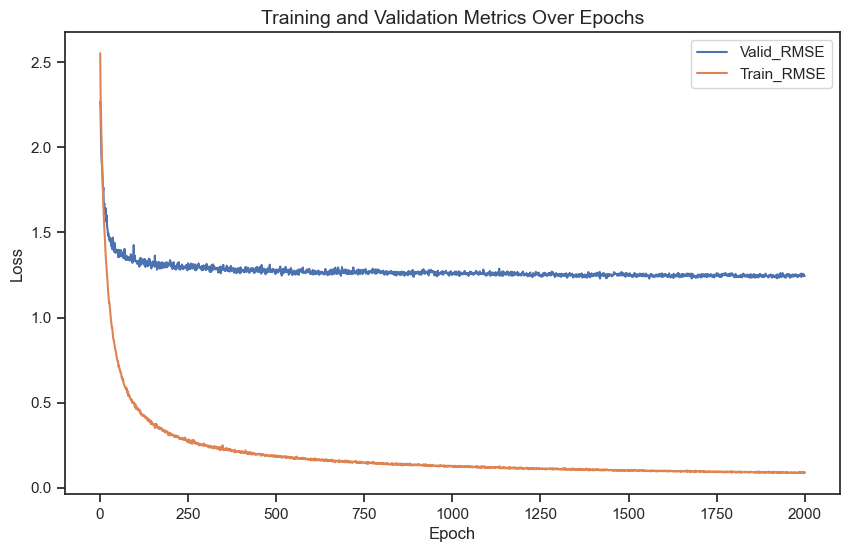

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [12]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.089961,0.089939,0.220922,0.220922,0.967949,0.983845,0.171346,NaN,1.255644,0.787646,0.787646,0.526722,0.727662,0.544851,0.526807,0.967949,1.252912
1996,1997,0.085807,0.085822,0.217618,0.217618,0.969416,0.984589,0.170145,NaN,1.244081,0.785460,0.785460,0.531080,0.730799,0.538590,0.531379,0.969416,1.241389
1997,1998,0.088632,0.088581,0.217596,0.217596,0.968433,0.984090,0.167932,NaN,1.246936,0.785831,0.785831,0.530004,0.730150,0.533081,0.530359,0.968433,1.244726
1998,1999,0.093397,0.093390,0.223315,0.223315,0.966719,0.983219,0.172803,NaN,1.244491,0.785649,0.785649,0.530926,0.731363,0.540632,0.531889,0.966719,1.242304
1999,2000,0.087905,0.087895,0.218075,0.218075,0.968677,0.984215,0.169044,NaN,1.243568,0.782972,0.782972,0.531273,0.731077,0.538501,0.531932,0.968677,1.241070


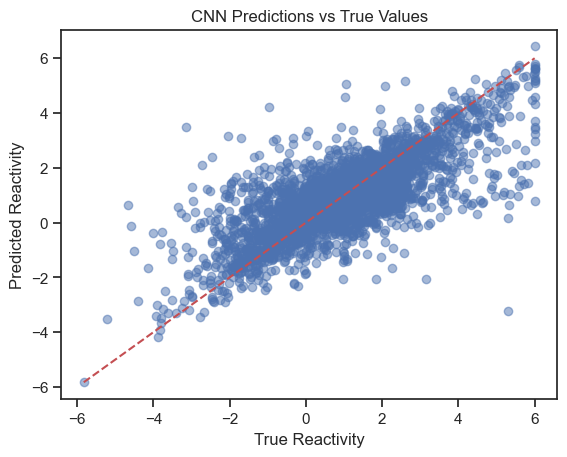

In [13]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
